In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("data").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/13 11:45:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [52]:
from pathlib import Path
lymsys_folder = Path("/Users/hamzaboukhriss/Desktop/Bigdata/lymsys")
wildchat_folder = Path("/Users/hamzaboukhriss/Desktop/Bigdata/wildchat")

In [56]:

lymsys_df = spark.read.parquet(str(lymsys_folder))
lymsys_df.show(5)
wildchat_df1 = spark.read.parquet(str(wildchat_folder))
wildchat_df1.show(5)
wildchat_df = wildchat_df1.unionByName(lymsys_df, allowMissingColumns=True)
wildchat_df.show(5)

+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|     conversation_id|     model|                       conversation|turn|  language|   openai_moderation|redacted|
+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|c20948192699451b8...|vicuna-13b|               [{Given the artic...|   1|   English|[{{false, false, ...|    true|
|8b02aa2df44847a1b...|vicuna-33b|               [{Alright, let's ...|   2|   English|[{{false, false, ...|    true|
|c18f3612fac140cb9...|vicuna-13b|[{あなたが最終更新されたのはいつ...|   5|  Japanese|[{{false, false, ...|   false|
|d1fabb62e3364665a...| llama-13b|               [{You are an AI a...|   1|   English|[{{false, false, ...|    true|
|b2da335248f04e439...| koala-13b|               [{Reescreva esse ...|   1|Portuguese|[{{false, false, ...|   false|
+--------------------+----------+-----------------------------------+----+----------+--

25/01/13 12:21:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+
|   conversation_hash|             model|          timestamp|                     conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|conversation_id|
+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|             [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United States|f96c8515aa663db23...|{en-US,en;q=0.9, .

In [58]:
from pyspark.sql.functions import when

# Create a column to assign device type based on user-agent (desktop vs mobile)
a_df = wildchat_df.withColumn(
	"device_type",
	when(
		F.lower(F.col("header.user-agent")).like("%mobile%"),
		"mobile"
	).otherwise("desktop")
)



a_df.show(16)


+--------------------+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+-----------+
|   conversation_hash|             model|          timestamp|                       conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|conversation_id|device_type|
+--------------------+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+-----------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|               [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United St

In [60]:
# Count the number of person using desktop and mobile as a device 
device_counts = a_df.groupBy("device_type").count()

device_counts.show()

+-----------+-------+
|device_type|  count|
+-----------+-------+
|    desktop|1765538|
|     mobile| 169813|
+-----------+-------+



In [63]:
#regional Preferences  
device_by_country_pivot = a_df.groupBy("country") \
    .pivot("device_type", ["mobile", "desktop"]) \
    .count() \
    .fillna(0) 

device_by_country_pivot.show()



+--------------------+------+-------+
|             country|mobile|desktop|
+--------------------+------+-------+
|              Russia| 25067| 111711|
|            Paraguay|    25|     35|
|               Macao|   301|    771|
|               Yemen|   429|    516|
|             Senegal|     4|     39|
|              Sweden|   283|   1454|
|          Cabo Verde|     1|      3|
|     The Netherlands|  2554|   7742|
|              Guyana|     0|     36|
|         Philippines|  2430|   7428|
|             Eritrea|     2|      5|
|              Jersey|     1|      0|
|            Djibouti|     0|      1|
|           Singapore|  1223|  11514|
|            Malaysia|   449|   3204|
|                Fiji|     1|     15|
|              Malawi|     1|      4|
|                Iraq|   335|    540|
|             Germany|  2906|  31575|
|Northern Mariana ...|     2|      0|
+--------------------+------+-------+
only showing top 20 rows



In [87]:
from pyspark.sql.functions import expr

# Calculate the percentage of mobile and desktop usage
# Add a column for the total number of devices per country
device_by_country_pivot = device_by_country_pivot.withColumn(
    "total_devices", 
    expr("mobile + desktop")
)

# Add a column for the percentage of mobile usage
device_by_country_pivot = device_by_country_pivot.withColumn(
    "mobile_percentage", 
    (F.col("mobile") / F.col("total_devices") * 100).cast("double")
)

# Add a column for the percentage of desktop usage
device_by_country_pivot = device_by_country_pivot.withColumn(
    "desktop_percentage", 
    (100 - F.col("mobile_percentage")).cast("double")
)

# Show the result
device_by_country_pivot.show()


+--------------------+------+-------+-------------+------------------+------------------+
|             country|mobile|desktop|total_devices| mobile_percentage|desktop_percentage|
+--------------------+------+-------+-------------+------------------+------------------+
|              Russia| 25067| 111711|       136778|18.326777698167835| 81.67322230183217|
|            Paraguay|    25|     35|           60| 41.66666666666667| 58.33333333333333|
|               Macao|   301|    771|         1072|28.078358208955223| 71.92164179104478|
|               Yemen|   429|    516|          945|  45.3968253968254|  54.6031746031746|
|             Senegal|     4|     39|           43|  9.30232558139535| 90.69767441860465|
|              Sweden|   283|   1454|         1737| 16.29245826137018| 83.70754173862983|
|          Cabo Verde|     1|      3|            4|              25.0|              75.0|
|     The Netherlands|  2554|   7742|        10296|24.805749805749805|  75.1942501942502|
|         

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


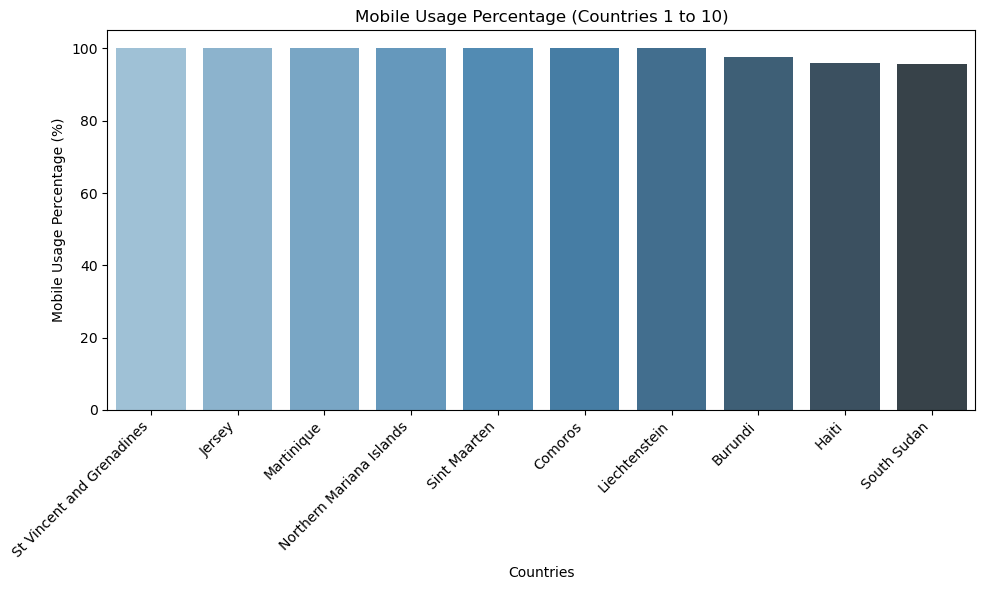

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


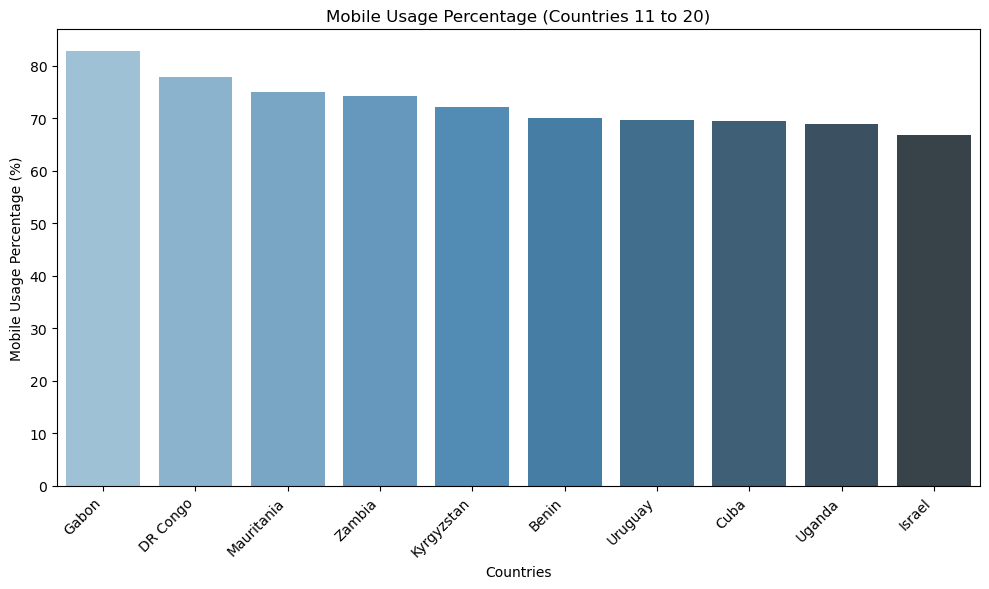

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


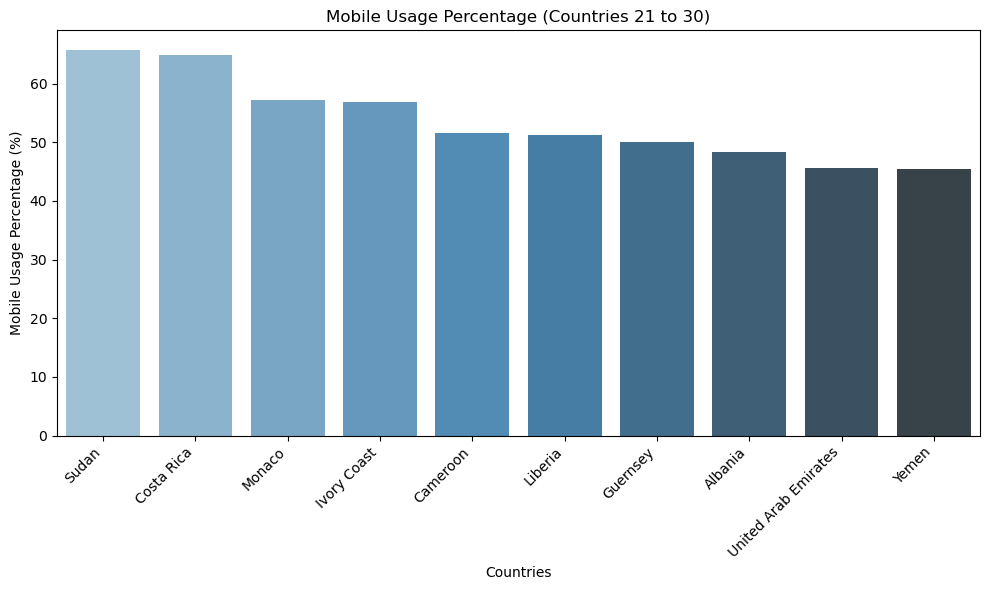

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


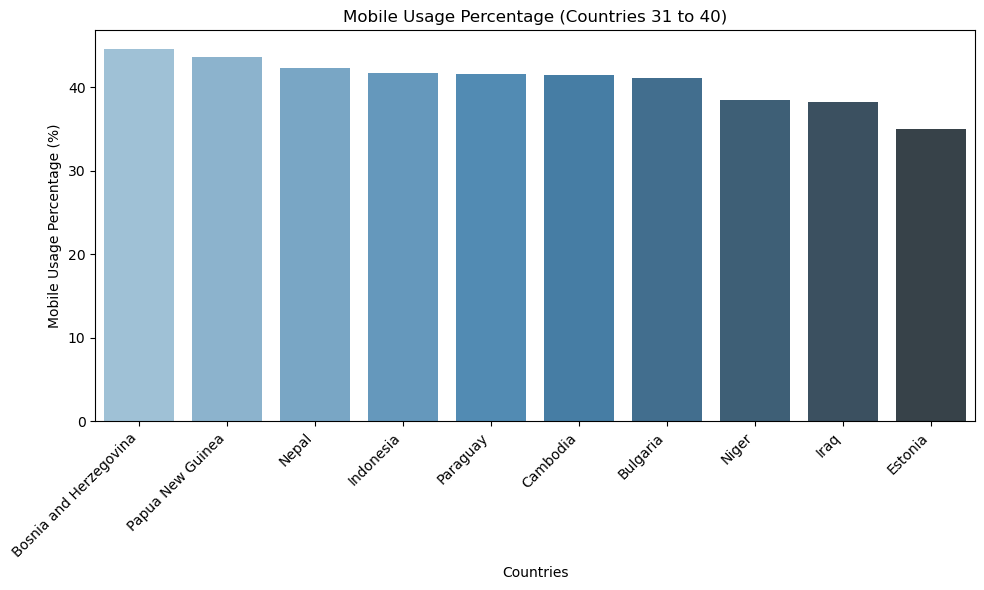

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


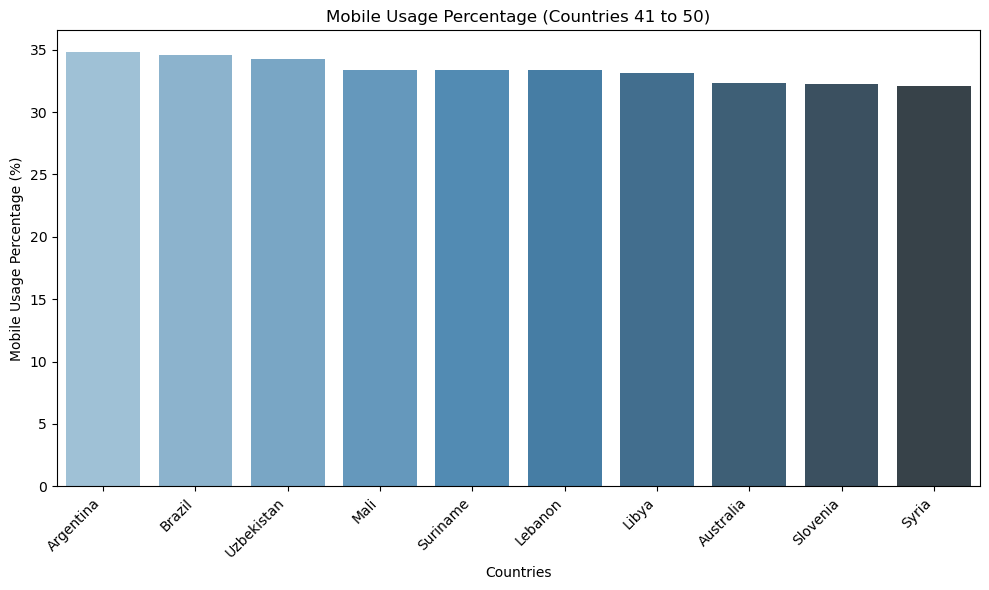

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


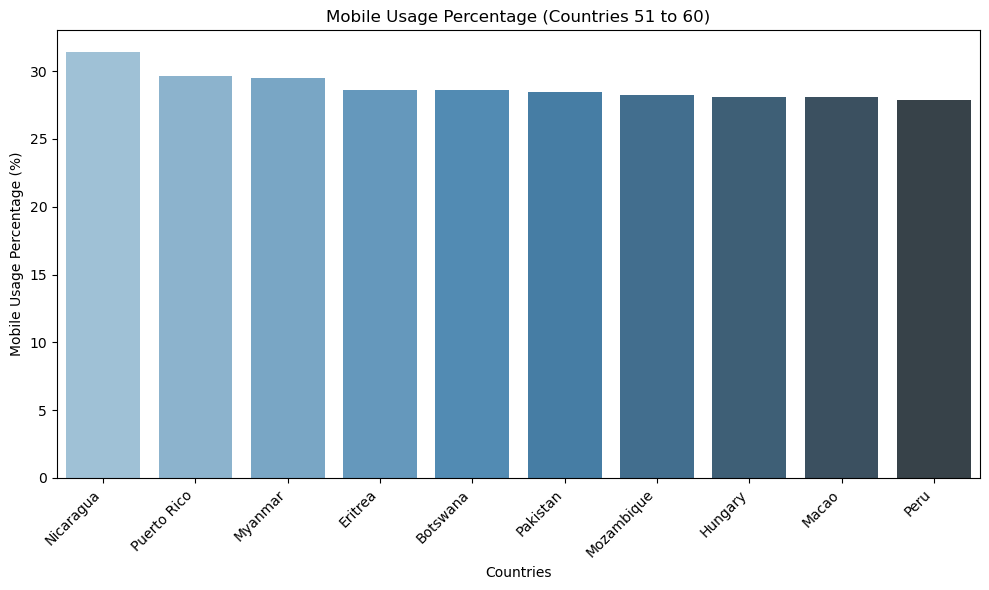

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


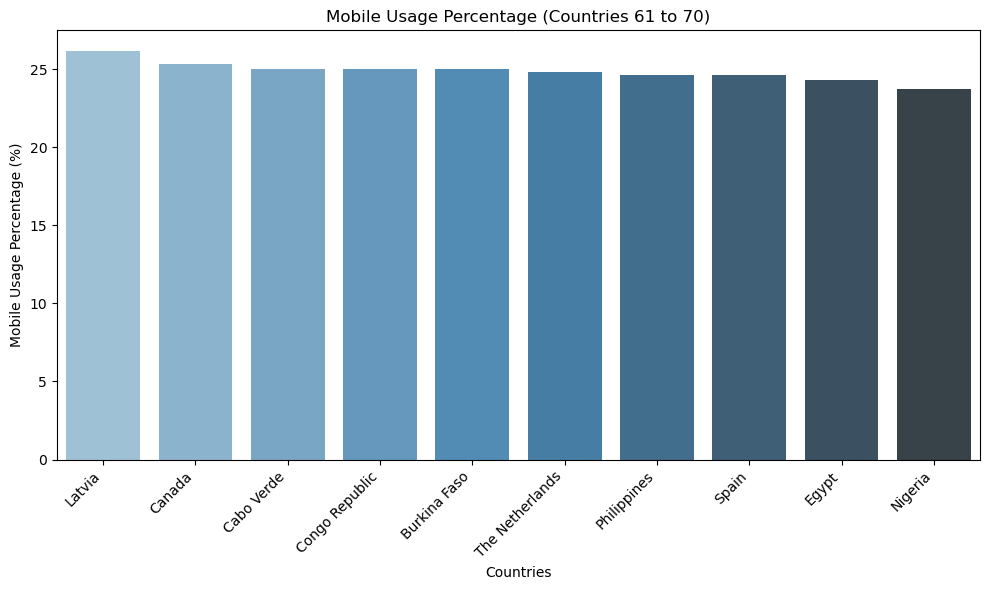

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


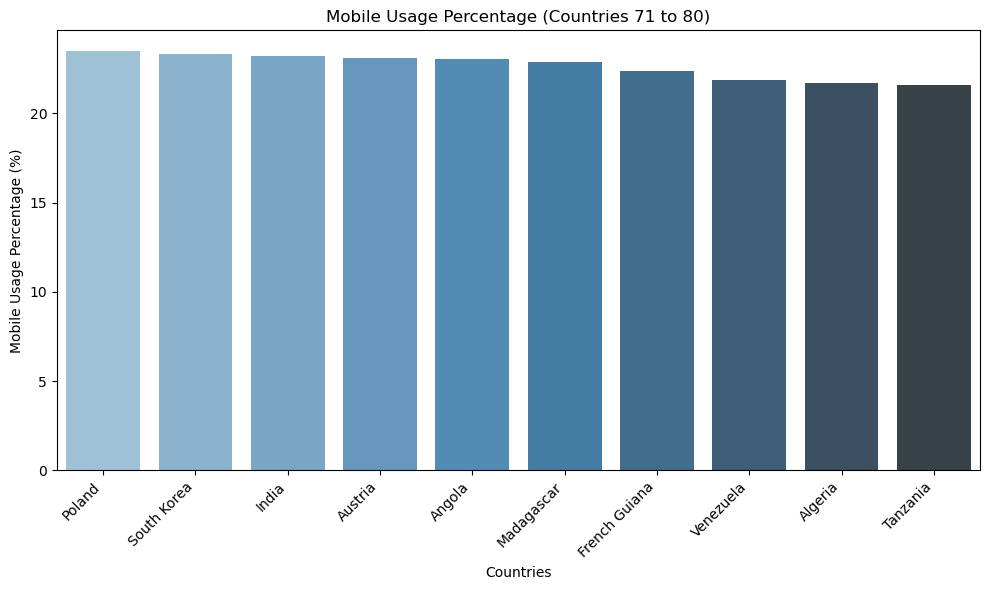

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


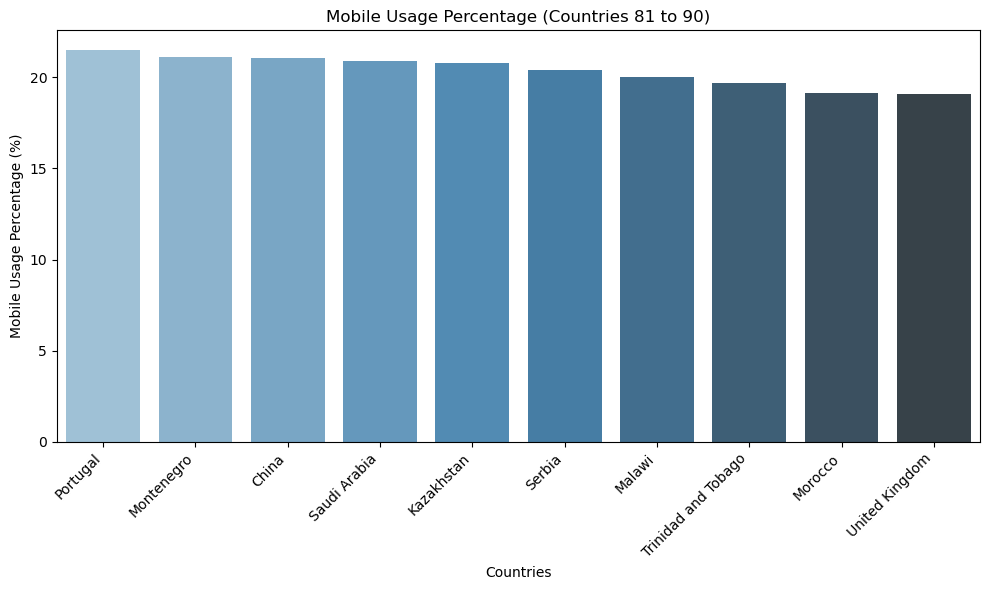

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


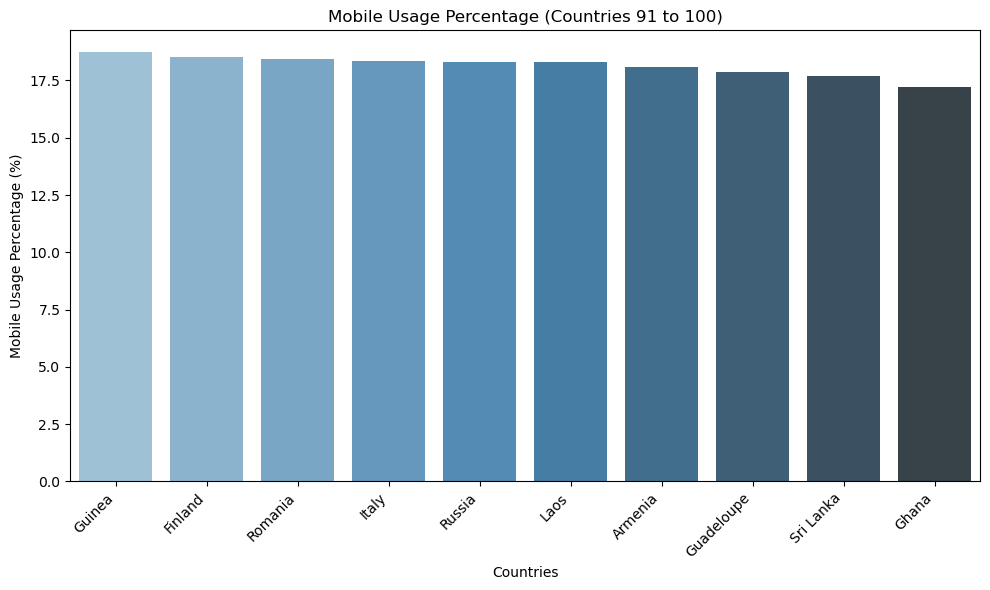

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


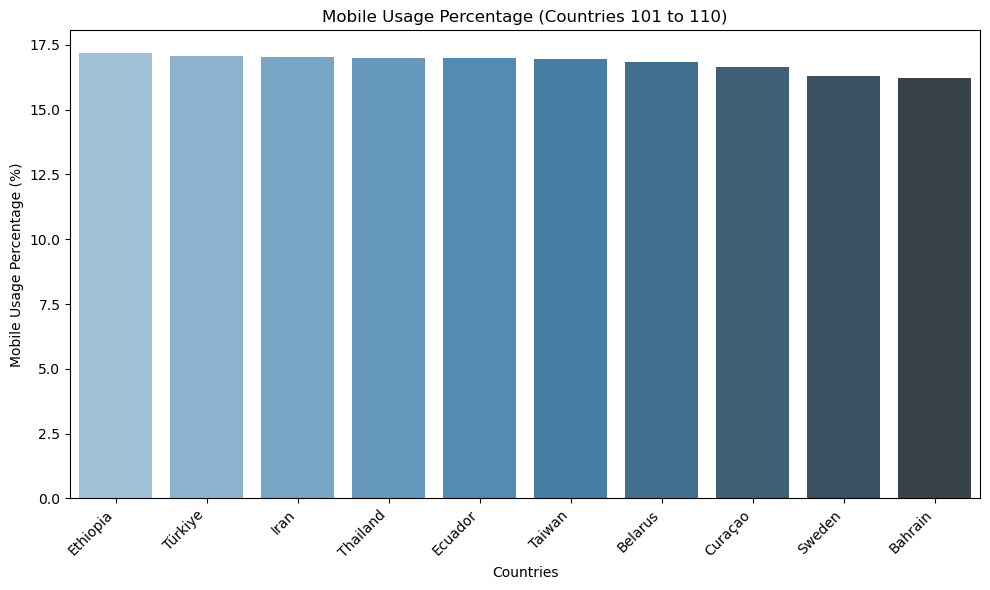

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


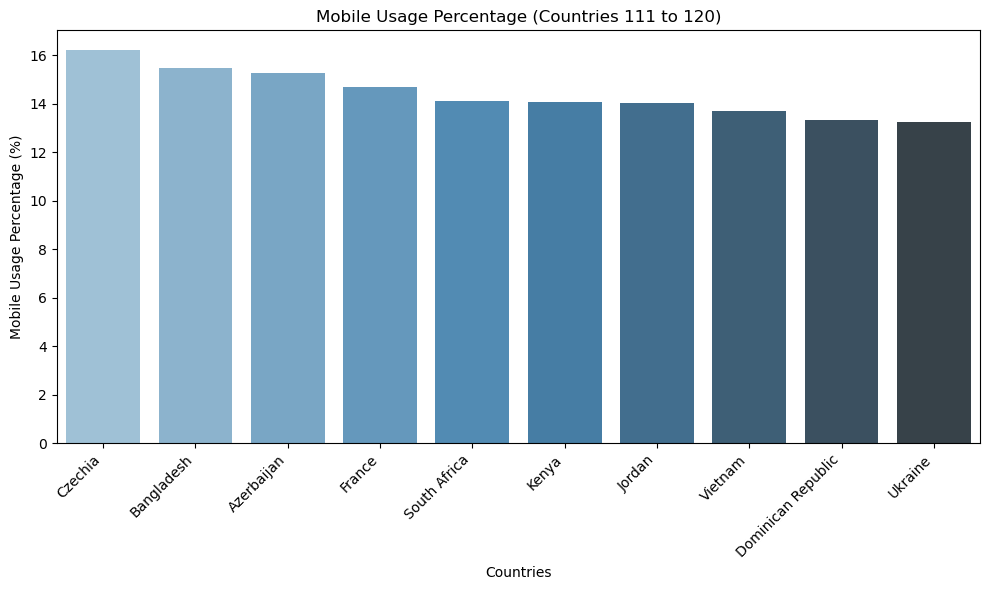

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


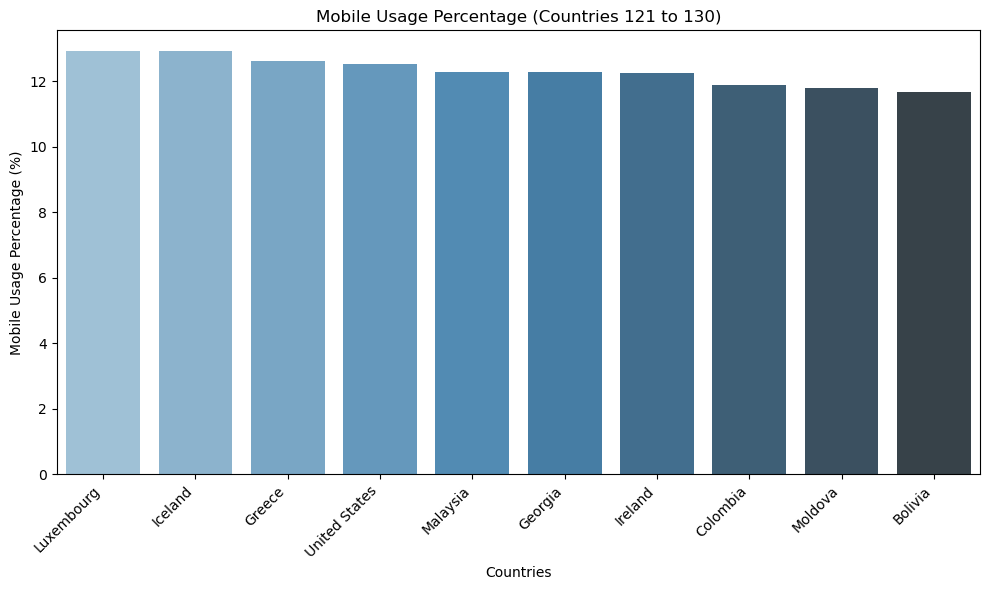

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


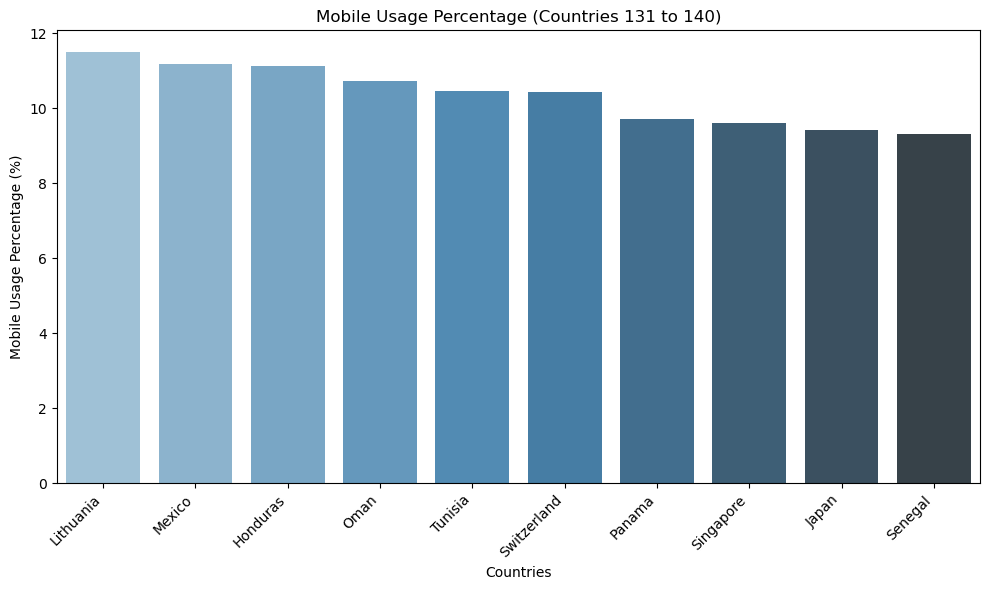

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


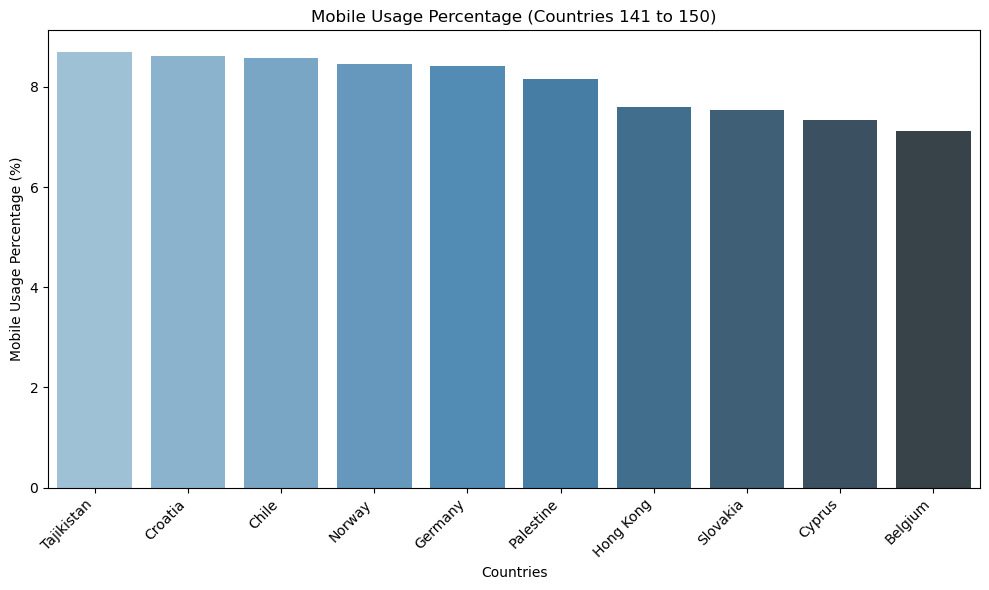

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


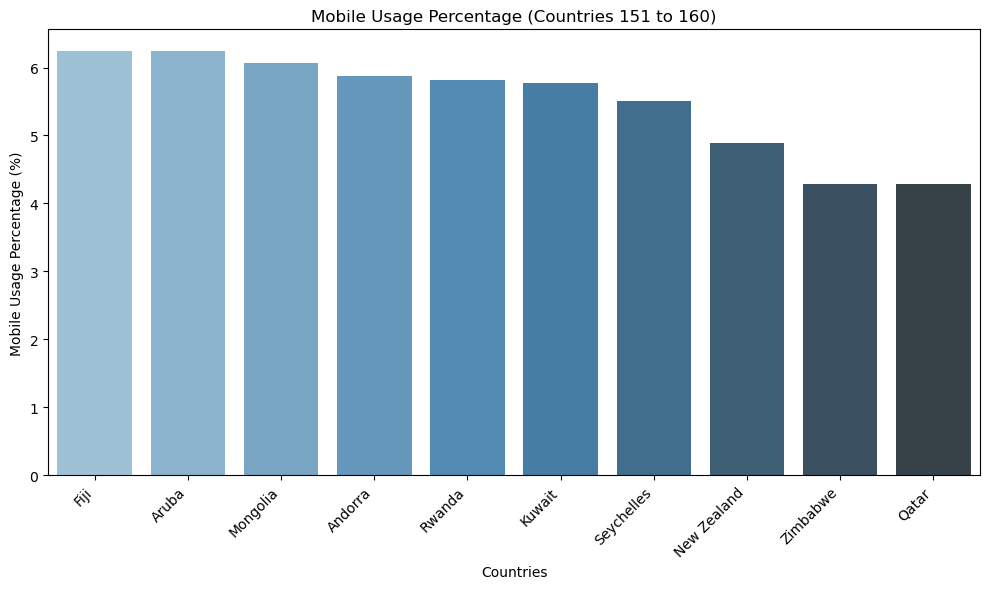

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


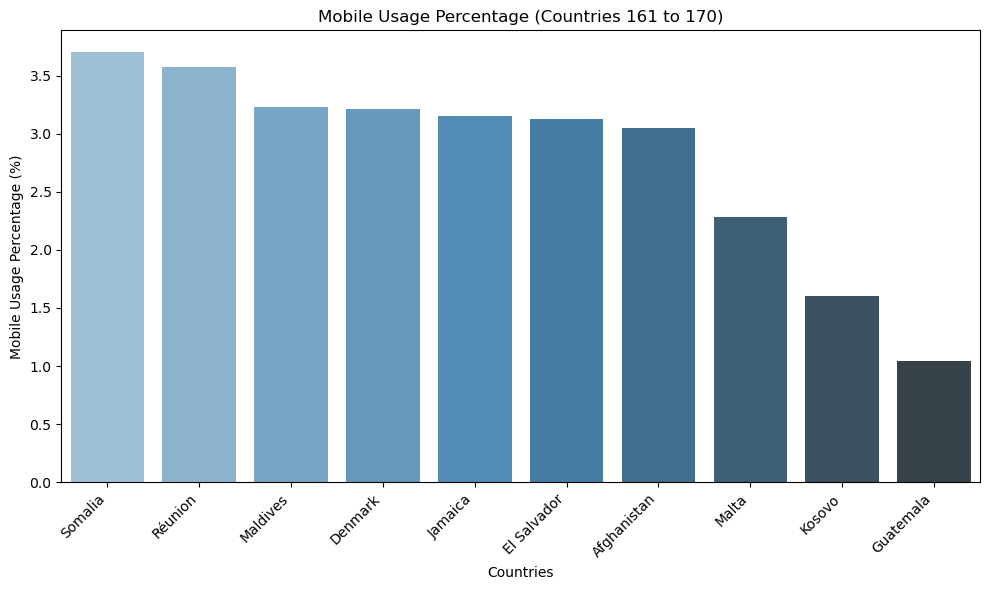

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


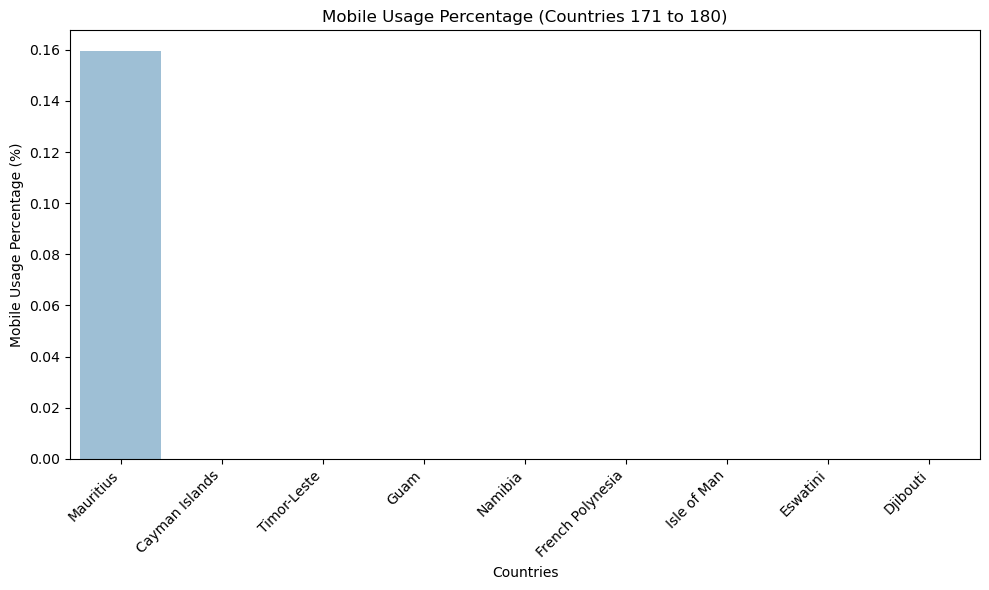

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


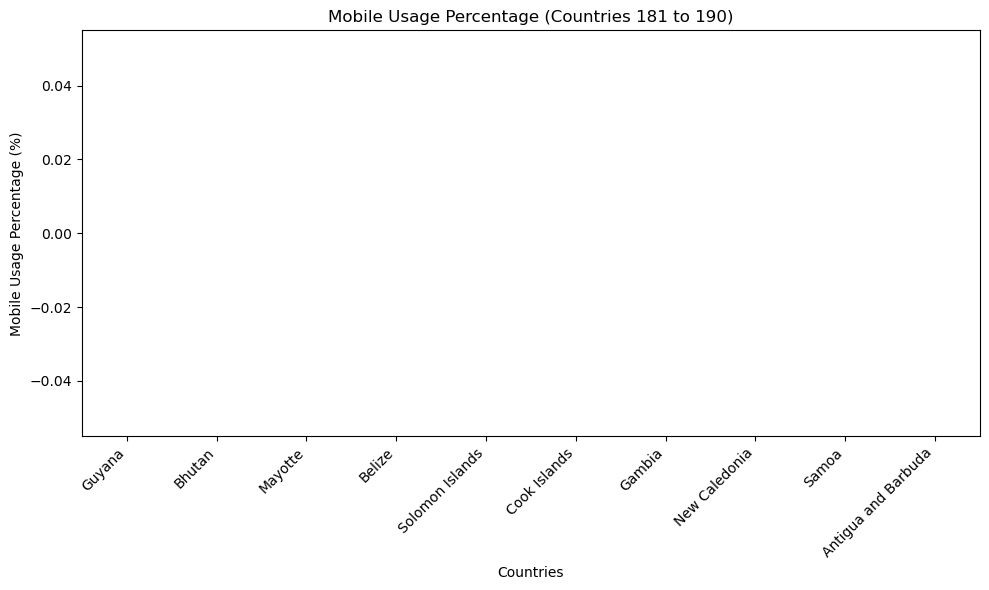

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


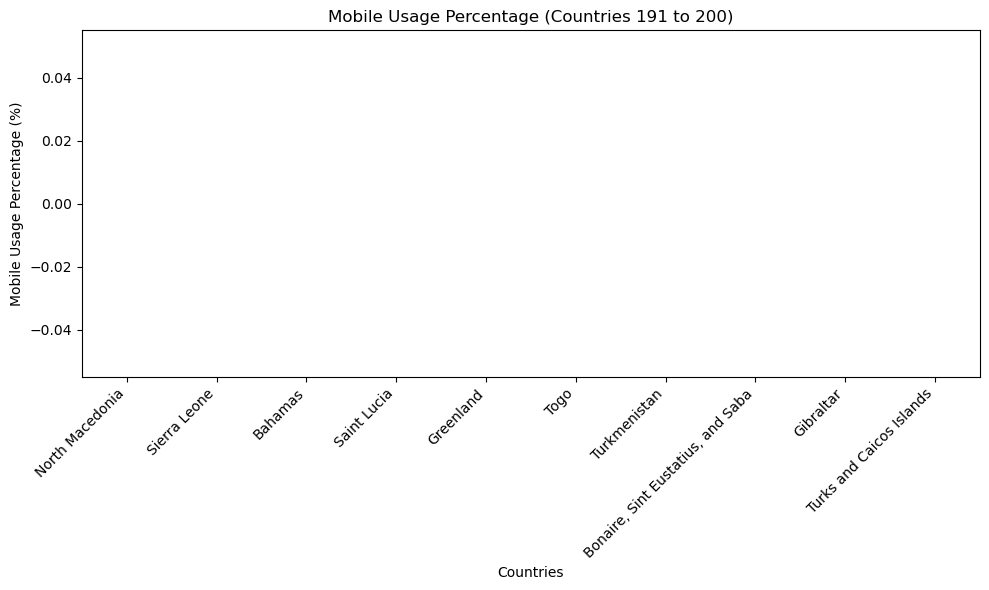

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


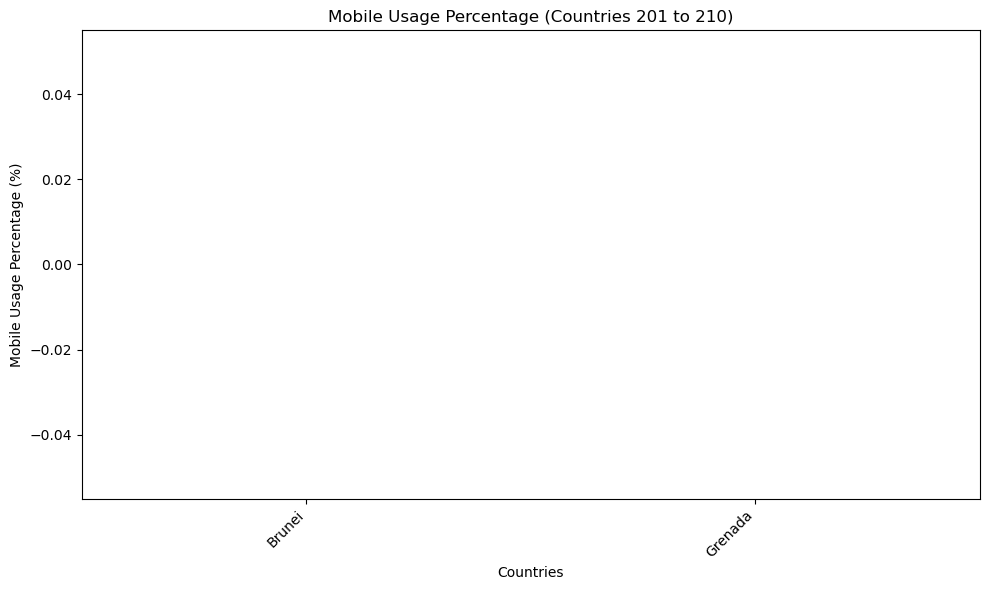

In [89]:
# Histogram of mobile usage percentage
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas
device_by_country_pivot_pd = device_by_country_pivot.select("country", "mobile_percentage").toPandas()

# Sort countries by mobile_percentage for better visibility
device_by_country_pivot_pd = device_by_country_pivot_pd.sort_values(by="mobile_percentage", ascending=False)

# Number of countries per plot
num_countries_per_plot = 10

# Split countries into groups of 10
num_plots = len(device_by_country_pivot_pd) // num_countries_per_plot + (1 if len(device_by_country_pivot_pd) % num_countries_per_plot > 0 else 0)

# Create multiple plots
for i in range(num_plots):
    # Subset of countries for each plot
    subset = device_by_country_pivot_pd.iloc[i*num_countries_per_plot : (i+1)*num_countries_per_plot]
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")
    
    # Add labels and a title
    plt.title(f"Mobile Usage Percentage (Countries {i*num_countries_per_plot+1} to {(i+1)*num_countries_per_plot})")
    plt.xlabel("Countries")
    plt.ylabel("Mobile Usage Percentage (%)")
    plt.xticks(rotation=45, ha="right")
    
    # Display the plot
    plt.tight_layout()
    plt.show()


/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


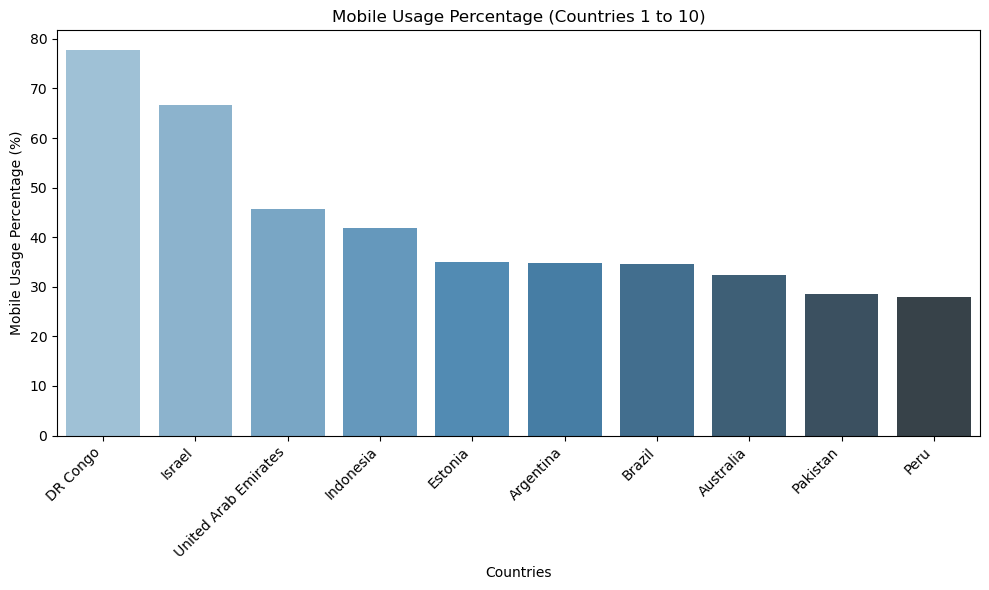

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


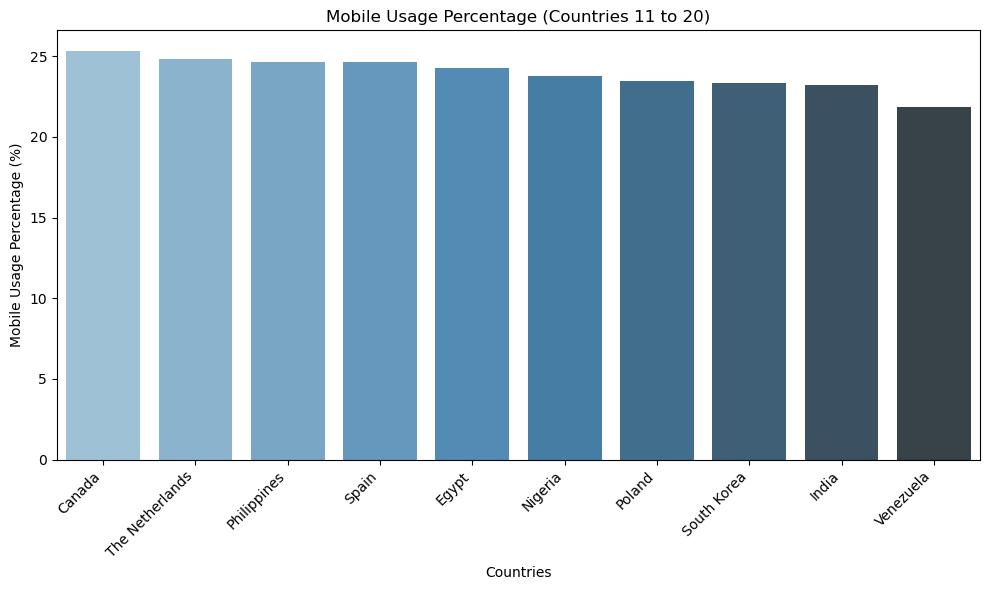

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


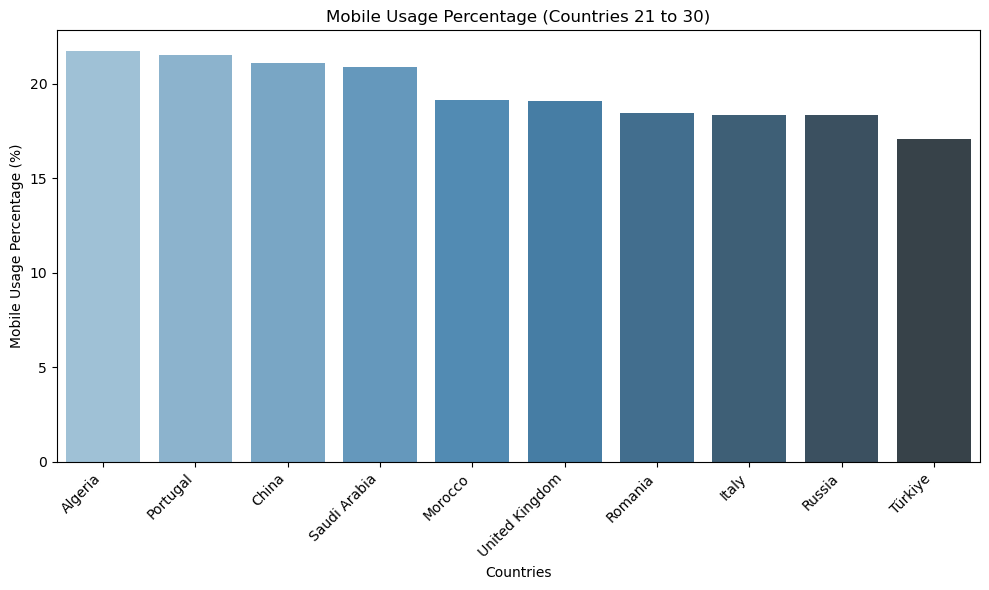

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


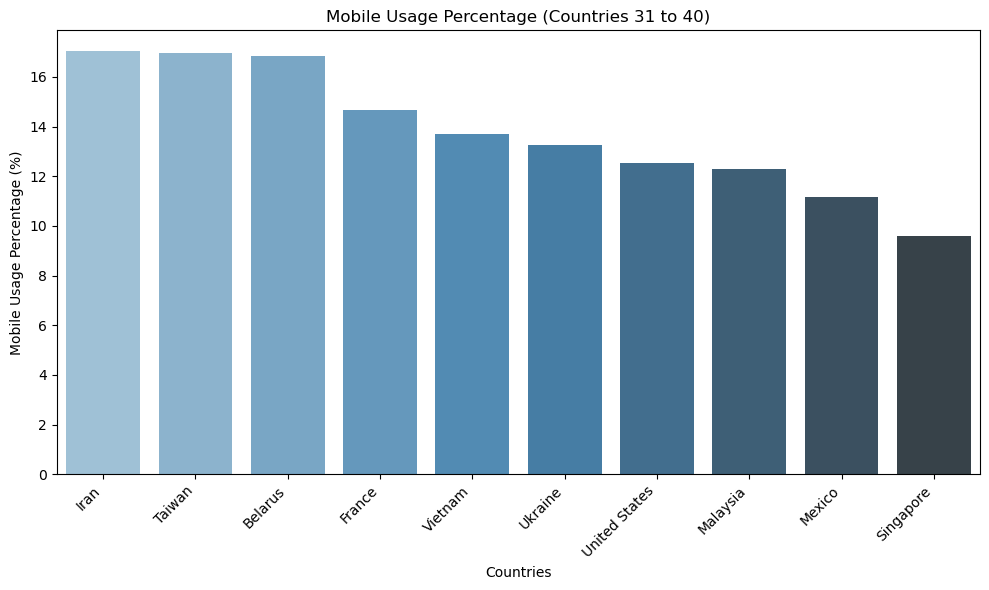

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_91632/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


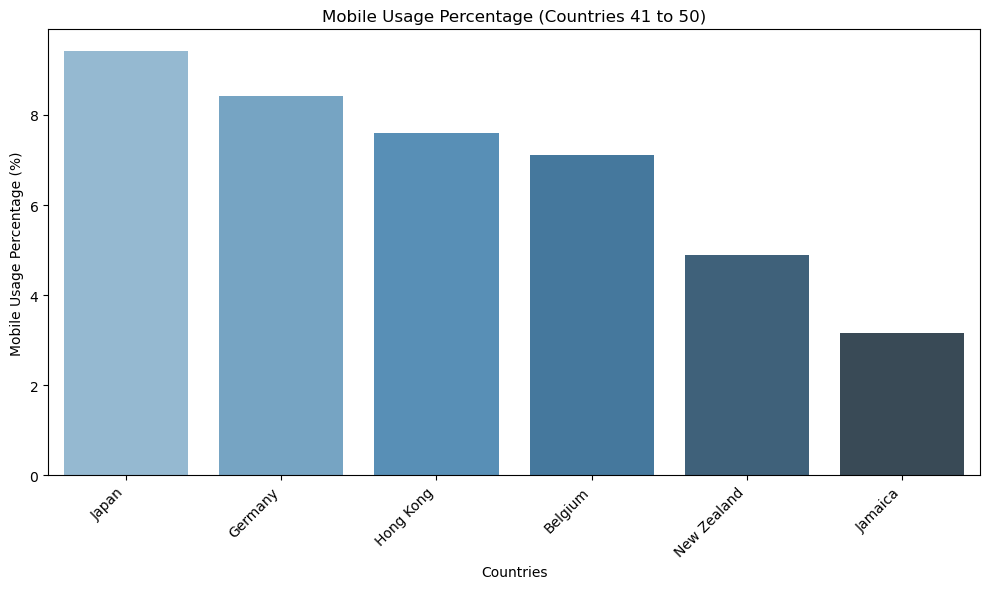

In [91]:
# Leave out some countries if the number of conversations is not enough
# Count the number of conversations per country
country_counts = a_df.groupBy("country").count()

# Filter countries with more than 2000 conversations
country_counts_filtered = country_counts.filter(country_counts["count"] > 2000)

# Retrieve the filtered countries as a list
valid_countries = [row['country'] for row in country_counts_filtered.collect()]

# Filter the original DataFrame to keep only these countries
device_by_country_pivot_pd_filtered = device_by_country_pivot_pd[device_by_country_pivot_pd['country'].isin(valid_countries)]

# Sort the filtered countries by percentage
device_by_country_pivot_pd_filtered = device_by_country_pivot_pd_filtered.sort_values(by="mobile_percentage", ascending=False)

# Create the plots as before
num_plots = len(device_by_country_pivot_pd_filtered) // num_countries_per_plot + (1 if len(device_by_country_pivot_pd_filtered) % num_countries_per_plot > 0 else 0)

for i in range(num_plots):
    # Subset of countries for each plot
    subset = device_by_country_pivot_pd_filtered.iloc[i*num_countries_per_plot : (i+1)*num_countries_per_plot]
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")
    
    # Add labels and a title
    plt.title(f"Mobile Usage Percentage (Countries {i*num_countries_per_plot+1} to {(i+1)*num_countries_per_plot})")
    plt.xlabel("Countries")
    plt.ylabel("Mobile Usage Percentage (%)")
    plt.xticks(rotation=45, ha="right")
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [69]:
pip install geopandas shapely


Note: you may need to restart the kernel to use updated packages.


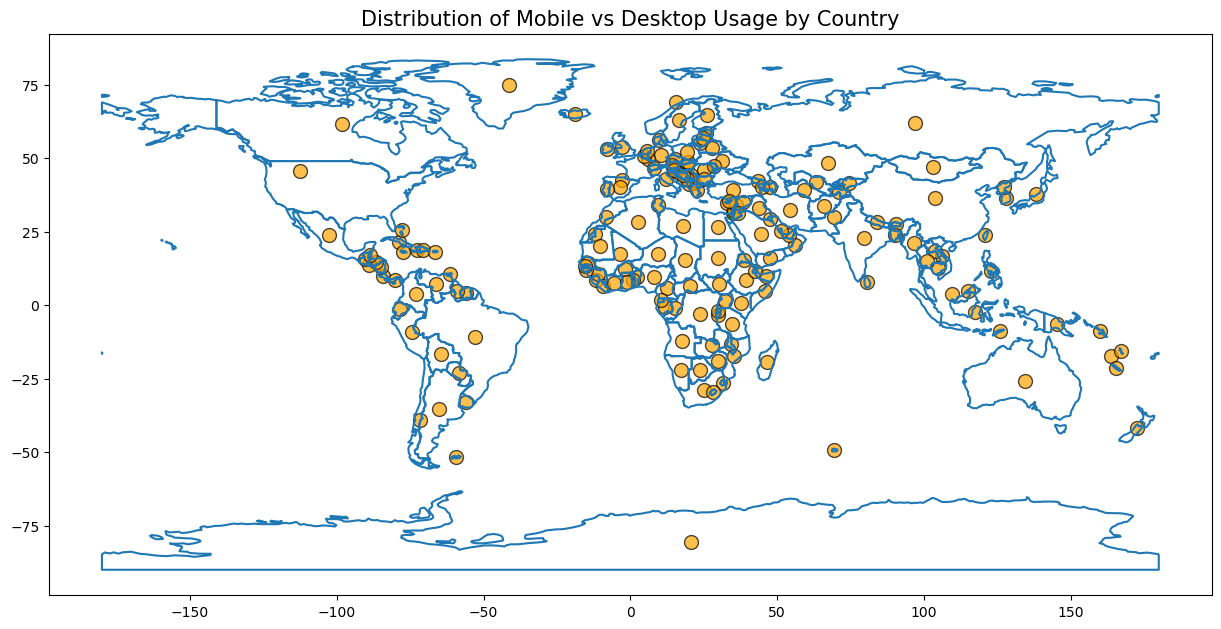

In [93]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the world map from a GeoJSON file
world = gpd.read_file("/Users/hamzaboukhriss/Desktop/Bigdata/planet.json")

# Convert the PySpark DataFrame to Pandas (make sure it contains the 'country' and 'mobile_percentage' columns)
device_by_country_pivot_pd_filtered = device_by_country_pivot_pd[device_by_country_pivot_pd['country'].isin(valid_countries)]

# Sort the filtered countries by percentage
device_by_country_pivot_pd_filtered = device_by_country_pivot_pd_filtered.sort_values(by="mobile_percentage", ascending=False)

# Merge the geographic data with the percentage data
merged = world.set_index('name').join(device_by_country_pivot_pd_filtered.set_index('country'))

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map boundary
world.boundary.plot(ax=ax)

# Add circles based on mobile usage percentage
for idx, row in merged.iterrows():
    # Condition: green for more mobiles, red for more desktops
    if row['mobile_percentage'] > 50:
        color = 'green'
    else:
        color = 'orange'
    
    # Plot a circle on the country with a size based on the mobile percentage
    ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y, color=color, s=100, edgecolor='black', alpha=0.7)

# Add a title
ax.set_title("Distribution of Mobile vs Desktop Usage by Country", fontsize=15)

# Display the plot
plt.show()


In [75]:
#group by continent (and do the same thing) 